In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import pandas as pd
import math


# Transformer


## getTrainingData


In [4]:
def getTrainingData(songStrings,nrOfSongs):
    notes=list("ABCDEFGH")
    chord=[[0],
           [1],
           [2],
           [3],
           [4],
           [5],
           [6],
           [7]]
    source=[]
    target=[]
    song=[]
    for s in range(nrOfSongs):
        for i in range(42):
            sentence=[]
            answer=[]
            song.append(s)
            for j in range(41):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return numpy.array(source),numpy.array(target),numpy.array(song)

songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

I,O,S=getTrainingData(songStrings,4)
print(I.shape,O.shape,S.shape)

(168, 41) (168, 41) (168,)


In [4]:
len(songStrings[0])

42

In [5]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [6]:
I.shape

(168, 41)

In [7]:
I

array([[2, 2, 6, ..., 4, 3, 3],
       [2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       ...,
       [0, 5, 1, ..., 2, 1, 5],
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0]])

In [8]:
S

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [9]:
print(I[0].flatten(),O[0].flatten())
print(I[1].flatten(),O[1].flatten())
print(I[2].flatten(),O[2].flatten())

print(I[-2].flatten(),O[-2].flatten())
print(I[-1].flatten(),O[-1].flatten())

[2 2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5
 4 4 3 3] [2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2]
[2 6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4
 4 3 3 2] [6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2]
[6 6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4
 3 3 2 2] [6 0 0 6 5 5 4 4 3 3 2 6 6 5 5 4 4 3 6 6 5 5 4 4 3 2 2 6 6 0 0 6 5 5 4 4 3
 3 2 2 2]
[5 1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4
 2 1 5 3] [1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2
 1 5 3 0]
[1 3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2
 1 5 3 0] [3 1 2 0 2 1 2 5 5 3 2 4 5 5 4 5 2 3 3 4 5 4 1 4 0 2 5 4 2 1 1 1 2 1 4 2 1
 5 3 0 5]


## Transformer Model


In [3]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)


c:\Users\ahmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Test


In [5]:
def test(model, source, target):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)

    with torch.no_grad():  # No need to track gradients
        src = source.transpose(0, 1)  # Adjust for the expected input dimensions [sequence_length, batch_size]
        tgt = target.transpose(0, 1)  # Same adjustment for the target
        
        output = model(src)  # Compute the output
        
        # The output is [sequence_length, batch_size, ntokens]. Get the most likely token predictions
        predictions = output.argmax(dim=2)  # Get the index of the max log-probability
        #print(predictions)
        correct += (predictions == tgt).sum().item()  # Count how many predictions match the target
        total += tgt.numel()  # Total number of predictions
        
    accuracy = correct / total  # Calculate the accuracy
    return accuracy

## Train


c:\Users\ahmad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\ahmad\AppData\Local\Temp\ipykernel_23996\2261244999.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_23996\2261244999.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tar

Epoch 1, Loss: 0.0124
acc: 0.14590592334494773


C:\Users\ahmad\AppData\Local\Temp\ipykernel_23996\1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_23996\1989781991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


Epoch 101, Loss: 0.0087
acc: 0.47865853658536583
Epoch 201, Loss: 0.0056
acc: 0.6369047619047619
Epoch 301, Loss: 0.0031
acc: 0.8176538908246226
Epoch 401, Loss: 0.0017
acc: 0.9168118466898955
Epoch 501, Loss: 0.0011
acc: 0.9464285714285714
Epoch 601, Loss: 0.0008
acc: 0.9628339140534262


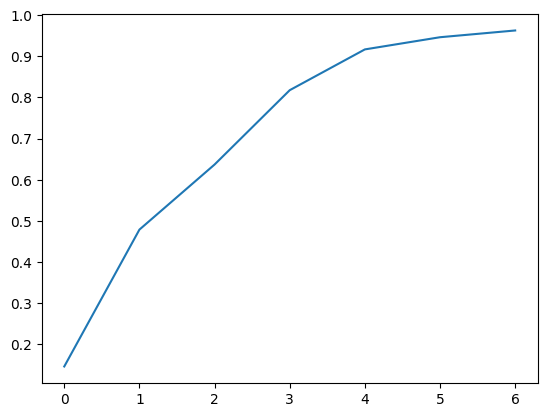

In [35]:
def train(model, source, target, num_epochs=1000, learning_rate=1e-3):
    W=[]
    model.train()  # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Assuming source and target are numpy arrays of shape (sentences, 41) and need to be converted to tensors
    source = torch.tensor(source, dtype=torch.long)
    target = torch.tensor(target, dtype=torch.long)
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Here, we assume batching is handled externally, and source is directly fed into the model
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        indices = torch.randperm(source.size(0))
        inputs_shuffled = source[indices]
        targets_shuffled = target[indices]
        # Adjust for PyTorch expecting (sequence_length, batch_size), so we transpose source and target
        src = inputs_shuffled.transpose(0, 1)  # Now shape [41, sentences]
        tgt = targets_shuffled.transpose(0, 1)  # Now shape [41, sentences]
        
        output = model(src)  # Forward pass: compute the output of the model
        
        # Output is [sequence_length, batch_size, ntokens], target is [sequence_length, batch_size]
        # Flatten output to [sequence_length*batch_size, ntokens] for compatibility with CrossEntropyLoss
        output_flat = output.view(-1, model.ntokens)
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(output_flat, tgt_flat)  # Compute the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        total_loss += loss.item()
        
        avg_loss = total_loss / src.size(1)  # average loss per sentence
        if epoch % 100 ==0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
            W.append(test(model,source,target))
            print("acc:",W[-1])
        if  W[-1]>0.95:
            break    
    return W
# Example usage
# Assuming `model` is your model instance, and `source`, `target` are your data tensors

ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.00  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)

nrOfSongs=4
source,target,songs=getTrainingData(songStrings,nrOfSongs)

W=train(model, torch.tensor(source), torch.tensor(target),num_epochs=10000)
plot(W)
model_name = 'Transformer'
transformer_model = model
torch.save(transformer_model, f'./SongModels/model_{model_name}_songs.model')


In [21]:
model.store[-1].shape

(168, 20)

In [22]:
source,target,songs=getTrainingData(songStrings,4)


In [ ]:
source.shape

(168, 41)

In [ ]:
target.shape

(168, 41)

In [ ]:
songs.shape

(168,)

In [ ]:
test(model,torch.tensor(source),torch.tensor(target))

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source, dtype=torch.long)
/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_969/1989781991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long)


0.9700929152148664

## predict_next_token


In [37]:
def predict_next_token(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    src = torch.tensor(token_indices, dtype=torch.long).unsqueeze(1)  # Shape [sequence_length, 1] to match expected input

    with torch.no_grad():
        output = model(src,verbose)  # Get model output for the entire sequence

    # Assuming output is [sequence_length, 1, ntokens] and we're interested in the last token's prediction
    last_token_logits = output[-1, 0, :]  # Get logits for the last token
    predicted_token_index = last_token_logits.argmax().item()  # Find the index of the max log-probability
    
    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]
who=34
source[who]
predicted_token_index = predict_next_token(model, source[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(target[who][-1])

torch.Size([41, 1, 20])
Predicted next token index: 0
0


In [ ]:
    for i in range(len(songs)):
        print(i,songs[i])
        print("source",source[i])


0 0
source [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4]
1 0
source [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
2 0
source [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
3 0
source [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
4 0
source [4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4
 5 0 1 2]
5 0
source [5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
 0 1 2 3]
6 0
source [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0
 1 2 3 4]
7 0
source [1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1
 2 3 4 5]
8 0
source [2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
9 0
source [3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3
 4 5 0 1]
10 0
source [4 5 0 1 2 3 4 5 0 1 2 3 4 5

## shrinkingDecompositionInformation


In [94]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getAllIOH(model,source,target,songs,width=20):
    I=[]
    O=[]
    H=[]
    for i in range(len(songs)):
        I.append(songs[i])
        predicted_token_index = predict_next_token(model, source[i])
        if predicted_token_index==target[i][-1]:
            O.append(1)
        else:
            O.append(0)
        H.append(list(model.store[-1].flatten()))
    H=numpy.array(H).transpose()
    print(H.shape)
    imshow(H)
    B=numpy.zeros(H.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
    print(B.shape)
    H=numpy.zeros((H.shape[1]))
    for i in range(width):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return numpy.array(I),numpy.array(O),H

def shrinkingDecompositionInformation(model,source,target,songs,numbers=[0,1,2,3],width=20):
    allI,allO,H=getAllIOH(model,source,target,songs,width=width)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1*(songs==number)).astype(int)
        O=(I*allO).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
        print(f"I: {I}")
        print(f"O: {O}")
    return collectorSet,collectorH

def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)
    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]
    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)



In [ ]:
s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(4)),width=20)

In [39]:
M=removalIntoMatrix(s,20,h)

In [40]:
print(M.shape)

(4, 20)


0.8112781244591316 0.0


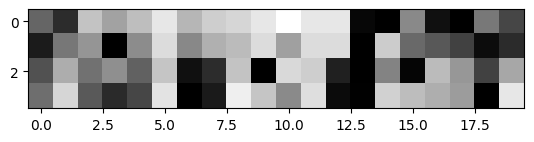

In [41]:
imshow(M,cmap="gray")
print(M.max(),M.min())

In [29]:
print(M.mean(),M.std())

0.4127551098296699 0.27312479520682564


In [30]:
print(songs)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


(20, 168)
(20, 168)


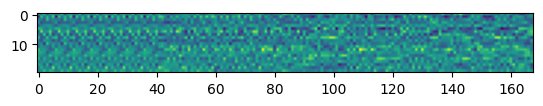

In [31]:
allI,allO,H=getAllIOH(model,source,target,songs,width=20)

In [ ]:
number=5
I=(1*(songs==number)).astype(int)
O=(target.transpose()[-1]==allO)

In [ ]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
allO

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
allI

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
model.state_dict().keys()
#model.state_dict().values()

odict_keys(['pos_encoder.pe', 'transformer_encoder.layers.0.self_attn.in_proj_weight', 'transformer_encoder.layers.0.self_attn.in_proj_bias', 'transformer_encoder.layers.0.self_attn.out_proj.weight', 'transformer_encoder.layers.0.self_attn.out_proj.bias', 'transformer_encoder.layers.0.linear1.weight', 'transformer_encoder.layers.0.linear1.bias', 'transformer_encoder.layers.0.linear2.weight', 'transformer_encoder.layers.0.linear2.bias', 'transformer_encoder.layers.0.norm1.weight', 'transformer_encoder.layers.0.norm1.bias', 'transformer_encoder.layers.0.norm2.weight', 'transformer_encoder.layers.0.norm2.bias', 'transformer_encoder.layers.1.self_attn.in_proj_weight', 'transformer_encoder.layers.1.self_attn.in_proj_bias', 'transformer_encoder.layers.1.self_attn.out_proj.weight', 'transformer_encoder.layers.1.self_attn.out_proj.bias', 'transformer_encoder.layers.1.linear1.weight', 'transformer_encoder.layers.1.linear1.bias', 'transformer_encoder.layers.1.linear2.weight', 'transformer_encode

In [ ]:
I.shape

(41, 8)

In [ ]:
O.shape

(41, 8)

# RNN models


## RNN


In [11]:
class RNN(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x,verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = copy.deepcopy(self.h0.detach().numpy())
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## Attention layer


In [12]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNNA


In [13]:
class RNNA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(RNNA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)
        
        expanded_attn_out = self.expand_layer(attn_out)
        
        expanded_attn_out = torch.relu(expanded_attn_out)

        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        
        rnn_out, self.hidden = self.rnnLayer(expanded_attn_out, h0)
        self.store = self.hidden.detach().numpy().copy()
        out = self.outputLayer(rnn_out)

        return out
    
    

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


## LSTM


In [14]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)), torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        out, self.h0 = self.lstmLayer(x, self.h0)

        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)
        return out

        
    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    


## LSTMA


In [15]:
class LSTMA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(LSTMA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp)  

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        self.outputLayer = nn.Linear(int(self.hidden_dim/2), self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        out, self.h0 = self.lstmLayer(expanded_attn_out, self.h0)
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)
        self.store = hh
        out = self.outputLayer(out)  # Corrected line

        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    


## GRU


In [16]:
class GRU(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.GRULayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        x = self.expand_layer(x)
        x = torch.relu(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.GRULayer(x, self.h0)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.relu(step_input)

                out, h0 = self.GRULayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = self.outputLayer(out)
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## GRUA


In [17]:
class GRUA(nn.Module):
    def __init__(self, hidden_dim=20, inp=8):
        super(GRUA, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        self.attention = SelfAttention(inp) 
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        self.outputLayer = nn.Linear(self.hidden_dim, self.inp)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x, verbose= False):
        attn_out = self.attention(x)

        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.relu(expanded_attn_out)

        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
    
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        self.store = self.h0.detach().numpy().copy()
        out = self.outputLayer(out)
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.relu(expanded_attn_out)

                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

    
                out = self.outputLayer(out)
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)



## generateIOData on all songs at once with its corresponding combinations


Input shape: (168, 41, 8), Output (One-Hot) shape: (168, 41, 8), Output (Indices) shape: (168, 41), Song shape: (168,)


Text(0.5, 1.0, 'Output (One-Hot Encoded)')

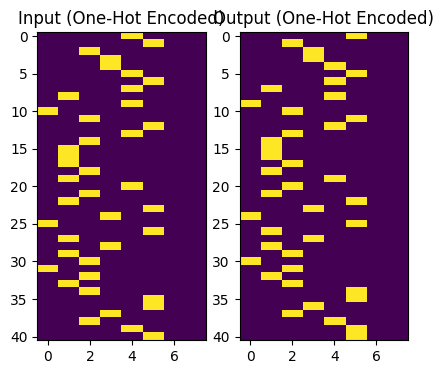

In [42]:
songStrings = numpy.array([
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC",
    "ABCDEFABCDEFABCDEFABCDEFABCDEFABCDEFABCDEF",
    "ABACADAEAFABEFADECBABCFEDEFABCADEBACADFABE",
    "DBCACBCFFDCEFFEFCDDEFEBEACFECBBBCBECBFDAFB",
    "ABEBCAEFCDFFBCBDBBBCEDCBFBFFECBCEBCAAFFADB",
    "BEEFBAFDAEAAEFDBDFDEFCACEBCCDACEACACEEDBAA",
    "BFEBFEEBDBCFEAACAAAFDFCBFBFEAACFFCAABCEDDC",
    "BADDFFEADBEDFDFBEBCCADEFDEABBFDEFFEBEEFDEF",
    "ABFFEDBDBFECEDEAEBBEECFDDAEDCDBBFCADADBBCF",
    "DFBCEBDAADAAFCDACADDAFFACDCFCCDDDCFBEBBDED",
    "CCFBEFDDCBFDADDBFBCCEEABAFAAAEDCDCEAEFBFCD",
    "EBADFFAAFADDDABEABBDFDCAFBCDEEBBBECDDFEEAE",
    "AFADDFEFADDBCDCFEEFCAEEEDFFEDBCADBBDBAEFCD"])

def generateIOData(nrOfSongs, songStrings):
    notes = list("ABCDEFGH")
    source = []
    target_one_hot = []
    target_indices = []
    songs = []  # Array to track the song index for each sequence

    for s in range(nrOfSongs):
        song_length = len(songStrings[s])
        for i in range(song_length):  # Adjust to iterate correctly
            input_one_hot = np.zeros((41, 8))
            current_target_one_hot = np.zeros((41, 8))
            current_target_indices = np.zeros(41, dtype=int)

            for j in range(41):
                note_index = notes.index(songStrings[s][(i+j) % song_length])
                next_note_index = notes.index(songStrings[s][(i+j+1) % song_length])

                input_one_hot[j, note_index] = 1
                current_target_one_hot[j, next_note_index] = 1
                current_target_indices[j] = next_note_index

            source.append(input_one_hot)
            target_one_hot.append(current_target_one_hot)
            target_indices.append(current_target_indices)
            songs.append(s)  # Append the song index

    return np.array(source), np.array(target_one_hot), np.array(target_indices), np.array(songs)

I, O_hot, O_indices, songs = generateIOData(4, songStrings)
print(f"Input shape: {I.shape}, Output (One-Hot) shape: {O_hot.shape}, Output (Indices) shape: {O_indices.shape}, Song shape: {songs.shape}")

# Display the first input and output for visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
who = 140
plt.imshow(I[who], aspect='auto')
plt.title("Input (One-Hot Encoded)")
plt.subplot(1, 4, 2)
plt.imshow(O_hot[who], aspect='auto')
plt.title("Output (One-Hot Encoded)")


In [40]:
songs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

## Train Rnns on all songs at once with its corresponding combinations


In [62]:
def train_model(model, num_epochs, songStrings, number_of_Songs):
    L = []  # Losses
    A = []  # Accuracies
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 1e-3)
    
    # Assuming generateIOData has been adjusted to take only songStrings
    I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
    #print(f"Input shape: {I.shape}, Output (Indices) shape: {O_indices.shape}")
    # Convert the dataset to tensors
    inputs = torch.tensor(I, dtype=torch.float)
    targets = torch.tensor(O_indices, dtype=torch.long)

    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Zero the gradients at the start of each epoch
        
        # Shuffle dataset
        indices = torch.randperm(inputs.size(0))
        inputs_shuffled = inputs[indices]
        targets_shuffled = targets[indices]
        
        # Assuming the model expects inputs of shape [seq_len, batch, feature]
        src = inputs_shuffled
        tgt = targets_shuffled
        #print(f"src shape: {src.shape}, tgt shape: {tgt.shape}")
        # Forward pass
        outputs = model(src)
        output_flat = outputs.view(-1, outputs.shape[-1])  # Flatten output for CrossEntropyLoss
        loss = criterion(output_flat, tgt.view(-1))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss = loss.item()

        # Calculate accuracy
        _, predicted_indices = torch.max(output_flat, 1)
        #print(f'predicted { predicted_indices}')
        #print(f'target {tgt.view(-1)}')
        correct_predictions = (predicted_indices == tgt.view(-1)).sum().item()
        total_accuracy = correct_predictions / tgt.numel()
        
        # Log the loss and accuracy
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {total_accuracy:.4f}')
        
        L.append(total_loss)
        A.append(total_accuracy)

        # Early stopping criteria (optional)
        if total_accuracy >= 0.95:
            print("Early stopping criteria met")
            break

    return L, A

In [63]:
model = RNN()
num_epochs = 5000
number_of_Songs = 4
L, A  = train_model(model, num_epochs, songStrings= songStrings, number_of_Songs = 4)

Epoch 1, Loss: 2.1319, Accuracy: 0.1089


Epoch 101, Loss: 1.6344, Accuracy: 0.4591
Epoch 201, Loss: 1.2077, Accuracy: 0.5671
Epoch 301, Loss: 0.9387, Accuracy: 0.7018
Epoch 401, Loss: 0.7147, Accuracy: 0.7690
Epoch 501, Loss: 0.5439, Accuracy: 0.8354
Epoch 601, Loss: 0.4224, Accuracy: 0.9010
Epoch 701, Loss: 0.3405, Accuracy: 0.9232
Epoch 801, Loss: 0.2865, Accuracy: 0.9398
Epoch 901, Loss: 0.2495, Accuracy: 0.9450
Early stopping criteria met


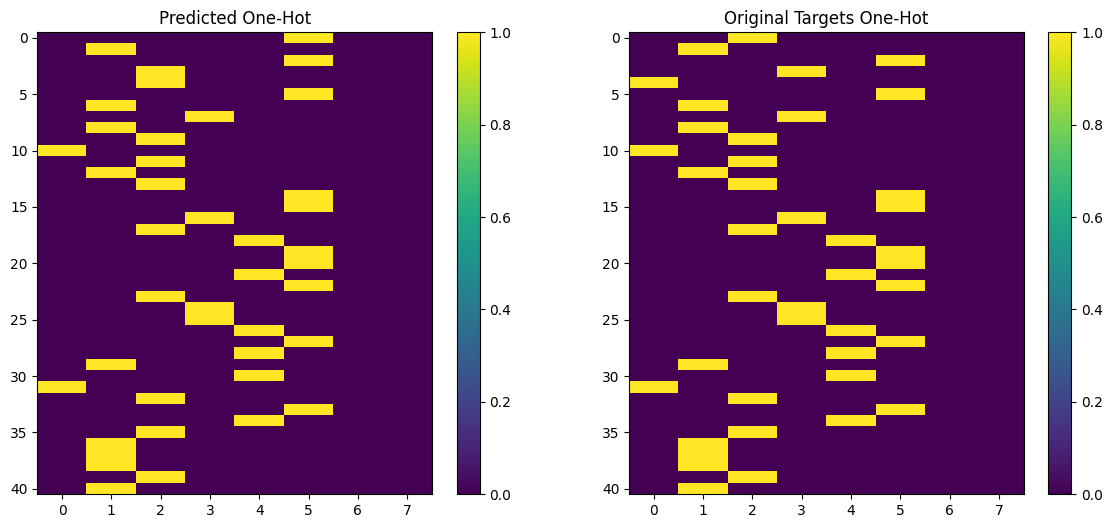

In [44]:
I, O, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset

inputs = torch.Tensor(I)
outputs = model(inputs)

_, predicted_indices = torch.max(outputs, 2)

num_classes = 8 

predicted_one_hot = F.one_hot(predicted_indices.squeeze(), num_classes=num_classes).numpy()


O_tensor = torch.tensor(O_indices, dtype=torch.long)
original_one_hot = F.one_hot(O_tensor, num_classes=num_classes).numpy()


plt.figure(figsize=(14, 6))
who = 160
# Plotting one-hot encoded predicted indices
plt.subplot(1, 2, 1)
plt.imshow(predicted_one_hot[who], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Predicted One-Hot')

# Plotting one-hot encoded original targets
plt.subplot(1, 2, 2)
plt.imshow(original_one_hot[who], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Original Targets One-Hot')

plt.show()

In [13]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA() 
    
}
number_of_Songs = 4
num_epochs = 10000
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    L , A = train_model(model, num_epochs, songStrings, number_of_Songs)
    results[model_name] = {"Accuracy": A, "Loss": L}
    torch.save(model, f'./SongModels/model_{model_name}_songs.model')


Training RNN...
Epoch 1, Loss: 2.1002, Accuracy: 0.1720
Epoch 101, Loss: 1.7311, Accuracy: 0.3924
Epoch 201, Loss: 1.2693, Accuracy: 0.5129
Epoch 301, Loss: 0.9028, Accuracy: 0.7101
Epoch 401, Loss: 0.6484, Accuracy: 0.7933
Epoch 501, Loss: 0.4826, Accuracy: 0.8776
Epoch 601, Loss: 0.3768, Accuracy: 0.9138
Epoch 701, Loss: 0.3066, Accuracy: 0.9370
Epoch 801, Loss: 0.2624, Accuracy: 0.9464
Epoch 901, Loss: 0.2330, Accuracy: 0.9474
Early stopping criteria met
Training RNNA...
Epoch 1, Loss: 2.0826, Accuracy: 0.1607
Epoch 101, Loss: 1.9103, Accuracy: 0.1826
Epoch 201, Loss: 1.7912, Accuracy: 0.2207
Epoch 301, Loss: 1.6227, Accuracy: 0.3410
Epoch 401, Loss: 1.3642, Accuracy: 0.4834
Epoch 501, Loss: 1.1992, Accuracy: 0.5510
Epoch 601, Loss: 0.9910, Accuracy: 0.6648
Epoch 701, Loss: 0.8747, Accuracy: 0.6792
Epoch 801, Loss: 0.7817, Accuracy: 0.6973
Epoch 901, Loss: 0.6836, Accuracy: 0.7589
Epoch 1001, Loss: 0.5909, Accuracy: 0.7983
Epoch 1101, Loss: 0.5153, Accuracy: 0.8230
Epoch 1201, Loss:

In [14]:
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Number of Epoch: {len(metrics['Accuracy'])}")
    print(f"Final Accuracy: {metrics['Accuracy'][-1]:.4f}")
    print(f"Final Loss: {metrics['Loss'][-1]:.4f}")



Model: RNN
Number of Epoch: 979
Final Accuracy: 0.9501
Final Loss: 0.2143

Model: RNNA
Number of Epoch: 2897
Final Accuracy: 0.9501
Final Loss: 0.1762

Model: LSTM
Number of Epoch: 5708
Final Accuracy: 0.9501
Final Loss: 0.1948

Model: LSTMA
Number of Epoch: 5501
Final Accuracy: 0.9502
Final Loss: 0.2116

Model: GRU
Number of Epoch: 665
Final Accuracy: 0.9501
Final Loss: 0.2462

Model: GRUA
Number of Epoch: 2960
Final Accuracy: 0.9501
Final Loss: 0.1810


In [15]:
model.store[-1].shape

(168, 20)

In [16]:
I, _, O_indices, songs = generateIOData(number_of_Songs,songStrings)  # Use the full dataset
I.shape

(168, 41, 8)

## predict_next_token


In [92]:
def predict_next_token(model, token_indices,verbose=False):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Convert the list of token indices to a PyTorch tensor and add a batch dimension
    inputs = torch.Tensor([token_indices])
    outputs = model(inputs)

    with torch.no_grad():
        outputs = model(inputs)

    _, predicted_indices = torch.max(outputs, 2)
    print(predicted_indices)

    
    #last_token_logits = output[-1, 0, :]  # Get logits for the last token
    #predicted_token_index =   # Find the index of the max log-probability
    predicted_token_index = predicted_indices[0, -1].item()  # Get the last item as a Python int

    return predicted_token_index

# Example usage:
# Assuming you have a `model` instance and a sentence represented as a list of token indices
# token_indices = [1, 2, 3, 2, 1, 2, 3, ...]
who=55
I[who]
#print(I[who])
print(O_indices[who])
predicted_token_index = predict_next_token(model, I[who],verbose=True)
print(f'Predicted next token index: {predicted_token_index}')
print(f"original target {O_indices[who][-1]}")


[2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2
 3 4 5 0]
tensor([[2, 0, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
         2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0]])
Predicted next token index: 0
original target 0


In [54]:
O_indices[who]

array([6, 6, 5, 5, 4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2,
       2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4])

tensor([2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5,
        5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3])
tensor([2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5,
        4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2])
tensor([2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4,
        4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2])
tensor([2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4,
        3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2])
tensor([0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3,
        2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2])
tensor([0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2,
        2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2])
tensor([2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2,
        2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 0])
tensor([5, 5, 4, 4, 

tensor([5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5,
        4, 4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2])
tensor([4, 4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4,
        4, 3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5])
tensor([4, 3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4,
        3, 2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5])
tensor([3, 3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3,
        2, 2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4])
tensor([3, 2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2,
        2, 5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4])
tensor([2, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3, 3, 2, 2, 2, 5, 5, 4, 4, 3, 2, 2,
        5, 5, 4, 4, 3, 2, 2, 2, 2, 0, 0, 2, 5, 5, 4, 4, 3])
tensor([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
        0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4])
tensor([1, 2, 3, 4, 

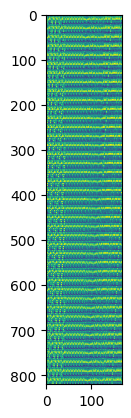

In [55]:
source, O_hot, target, songs = generateIOData(4, songStrings)

s,h=shrinkingDecompositionInformation(model,source,target,songs,numbers=list(range(4)),width=20)

In [56]:
M=removalIntoMatrix(s,20,h)

0.00856853999610463 -0.007828062947824677


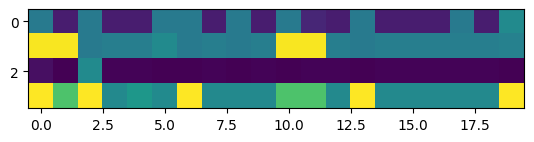

In [57]:
imshow(M)
print(M.max(),M.min())

# plot M

In [48]:
target

array([[2, 6, 6, ..., 3, 3, 2],
       [6, 6, 0, ..., 3, 2, 2],
       [6, 0, 0, ..., 2, 2, 2],
       ...,
       [5, 1, 3, ..., 1, 5, 3],
       [1, 3, 1, ..., 5, 3, 0],
       [3, 1, 2, ..., 3, 0, 5]])

tensor([[3, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5,
         4, 4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2]])
tensor([[3, 6, 5, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4,
         4, 3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2]])
tensor([[6, 5, 0, 6, 5, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4,
         3, 2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2]])
tensor([[6, 0, 3, 5, 5, 4, 4, 3, 3, 2, 2, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3,
         2, 2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6]])
tensor([[2, 2, 0, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2,
         2, 6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6]])
tensor([[2, 0, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2, 2,
         6, 6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6, 0]])
tensor([[6, 5, 4, 4, 3, 3, 2, 6, 6, 5, 5, 4, 4, 3, 6, 6, 5, 5, 4, 4, 3, 2, 2, 6,
         6, 0, 0, 6, 5, 5, 4, 4, 3, 3, 2, 2, 2, 6, 6, 0, 0]])

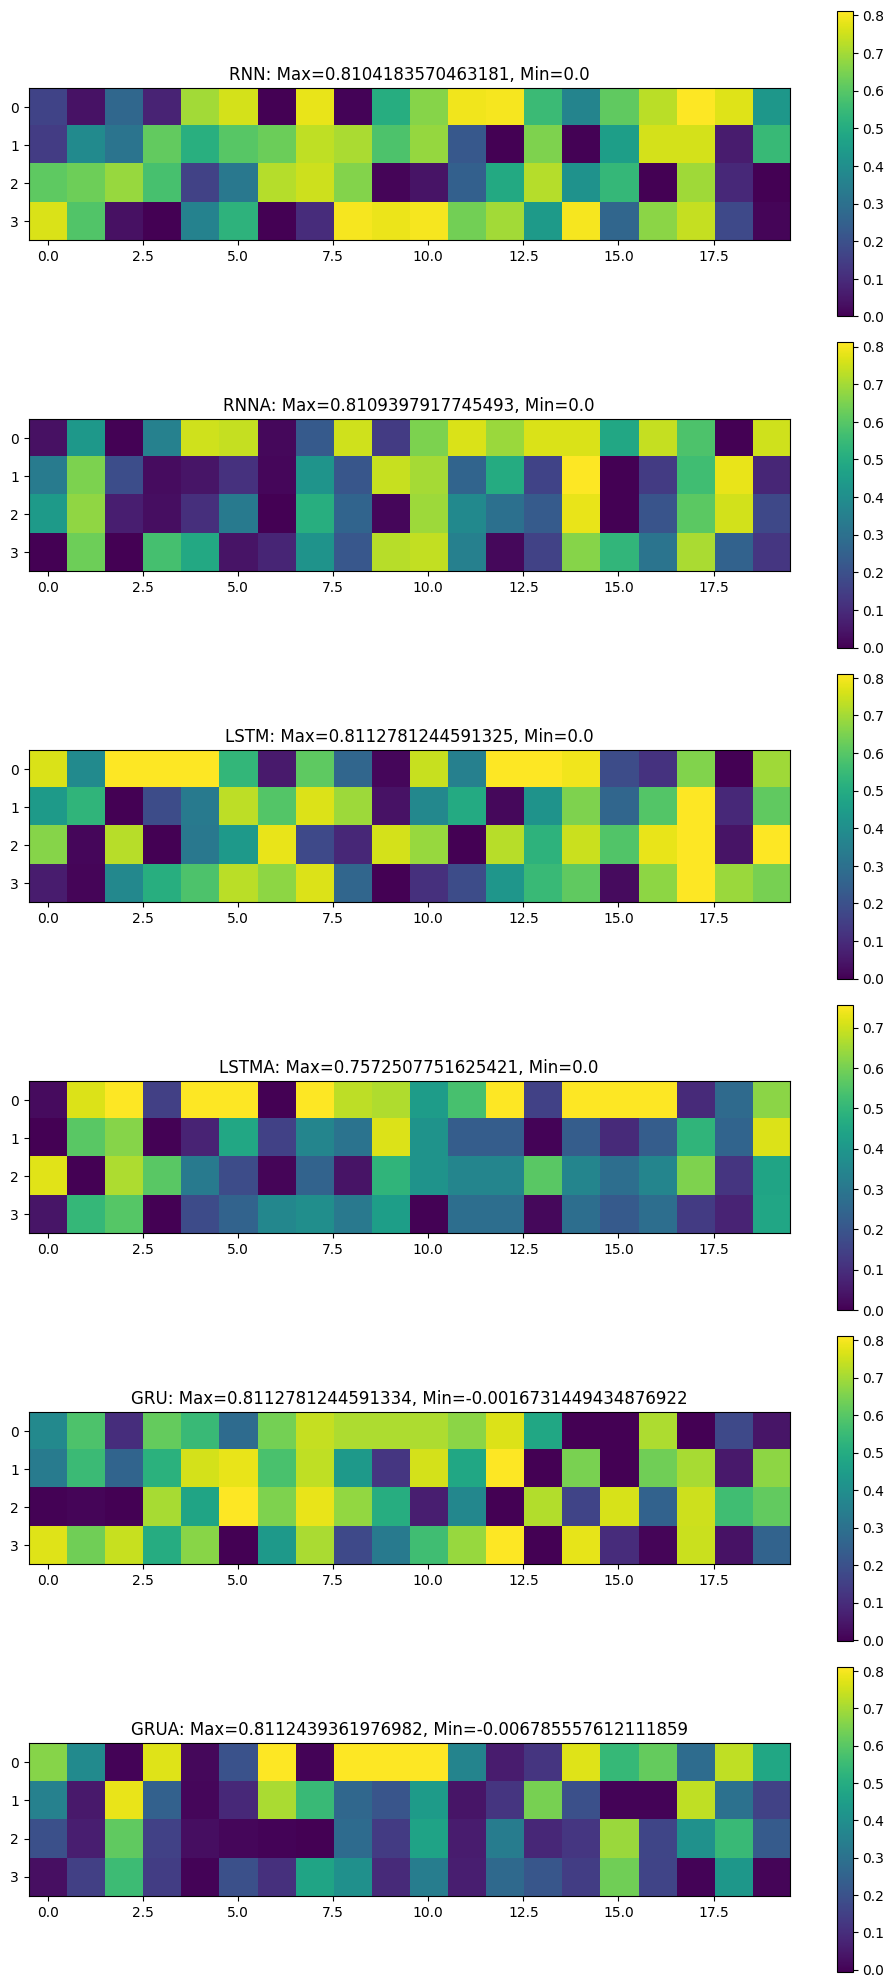

In [95]:
models = {
    "RNN": RNN(),
    "RNNA": RNNA(),  
    "LSTM": LSTM(),
    "LSTMA": LSTMA(),  
    "GRU": GRU(),
    "GRUA": GRUA(),
}
source, O_hot, target, songs = generateIOData(4, songStrings)
fig, axs = plt.subplots(len(models), 1, figsize=(10, 20))

# For each model, process the data and plot the resulting matrix
for i, (model_name, model) in enumerate(models.items()):
    model = torch.load(f'./SongModels/model_{model_name}_songs.model')
    model.eval()  # Set the model to evaluation mode if you're doing inference

    s, h = shrinkingDecompositionInformation(model, source, target, songs, numbers=list(range(4)), width=20)
    M = removalIntoMatrix(s, 20, h)
    
    ax = axs[i]
    cax = ax.imshow(M)
    fig.colorbar(cax, ax=ax)
    ax.set_title(f"{model_name}: Max={M.max()}, Min={M.min()}")

plt.tight_layout()
plt.show()


In [ ]:
M

array([[-0.01394116,  0.        , -0.01394116, -0.01021922, -0.01394116,
        -0.01394116, -0.01394116, -0.01394116, -0.01394116, -0.01021922,
        -0.01394116, -0.01021922, -0.01394116, -0.01021922, -0.01021922,
        -0.01021922, -0.01394116, -0.01394116, -0.01394116, -0.01394116],
       [-0.02607095, -0.02607095, -0.02607095, -0.02526978, -0.02607095,
        -0.02607095, -0.02607095, -0.02607095,  0.        , -0.02526978,
        -0.02607095, -0.02526978, -0.02607095, -0.02526978, -0.02526978,
        -0.02526978, -0.02607095, -0.02607095, -0.02607095, -0.02607095],
       [-0.02395571, -0.02395571,  0.        , -0.02395571, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.01398283, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.02395571, -0.02395571,
        -0.02395571, -0.02395571, -0.02395571, -0.02395571, -0.02395571],
       [ 0.01873013,  0.        ,  0.        ,  0.02300939,  0.01873013,
         0.01873013,  0.01873013,  0.01873013,  

In [19]:
def kmeans_thresholding(matrix, random_state=42):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply KMeans clustering with a fixed random state for reproducibility
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=random_state).fit(flat_matrix.reshape(-1, 1))

    centroids = kmeans.cluster_centers_.flatten()

    # Check if there are two centroids (clusters) and handle accordingly
    if len(centroids) > 1:
        # Determine threshold - you may choose a different method here
        threshold = np.mean(centroids)
    else:
        # If only one centroid (unlikely, but possible), use it as the threshold
        threshold = centroids[0]

    # Count the number of elements exceeding the threshold
    count_exceeding = np.sum(flat_matrix > threshold)

    return threshold, count_exceeding



In [21]:
def threshold_binarize_matrix(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply thresholding
    binarized_matrix = np.where(flat_matrix >= threshold, 1, 0)

    # Reshape to the original matrix shape
    binarized_matrix = binarized_matrix.reshape(matrix.shape)

    return binarized_matrix



In [22]:

def calculate_degrees_of_overlap(matrix):
    # Assuming 'matrix' is a NumPy array of shape (4, 20)
    degree_2, degree_3, degree_4 = 0, 0, 0

    # Transpose is not necessary as we want to work column-wise
    for col in range(matrix.shape[1]):  # Iterate through each column
        count_ones = np.sum(matrix[:, col] == 1)  # Count the number of ones in the current column
        if count_ones == 2:
            degree_2 += 1
        elif count_ones == 3:
            degree_3 += 1
        elif count_ones == 4:
            degree_4 += 1

    return degree_2, degree_3, degree_4



In [23]:
M

array([[-0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 ,
        -0.0264147 , -0.00704346, -0.0264147 , -0.0264147 , -0.0264147 ,
        -0.0264147 ,  0.        , -0.01311215, -0.0264147 , -0.0264147 ,
        -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 , -0.0264147 ],
       [-0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ,  0.        ,
        -0.03196544, -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ,
        -0.1386625 , -0.06142105, -0.1386625 , -0.1386625 , -0.1386625 ,
        -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 , -0.1386625 ],
       [-0.07864014, -0.02409398, -0.07864014, -0.07864014, -0.07864014,
        -0.07864014,  0.        , -0.07864014, -0.07864014, -0.07864014,
        -0.07864014, -0.07149082, -0.06206952, -0.07864014, -0.07864014,
        -0.07864014, -0.07864014, -0.07864014, -0.07864014, -0.07864014],
       [-0.00091821,  0.        , -0.00091821, -0.00091821,  0.00167111,
        -0.00091821,  0.00167111, -0.00091821, -

In [36]:
results = []
           
# Calculate metrics
sum_abs = np.sum(np.abs(M))
mean = np.mean(M)
std = np.std(M)
max_val = np.max(M)
min_val = np.min(M)

threshold_song_1, count_exceeding_song_1 = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
threshold_song_2, count_exceeding_song_2 = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
threshold_song_3, count_exceeding_song_3 = kmeans_thresholding(M[2]) # fix this K means of A alone then B alone
threshold_song_4, count_exceeding_song_4 = kmeans_thresholding(M[3]) # fix this K means of A alone then B alone

binarized_matrix_song_1 = np.where(M[0].flatten() >= threshold_song_1, 1, 0).reshape(M[0].shape) 
binarized_matrix_song_2 = np.where(M[1].flatten() >= threshold_song_2, 1, 0).reshape(M[1].shape)
binarized_matrix_song_3 = np.where(M[2].flatten() >= threshold_song_3, 1, 0).reshape(M[2].shape)
binarized_matrix_song_4 = np.where(M[3].flatten() >= threshold_song_4, 1, 0).reshape(M[3].shape)
count_exceeding_song_1_sum = np.sum(M[0] > threshold_song_1) # or use count_exceeding_song_1
count_exceeding_song_2_sum = np.sum(M[1] > threshold_song_2) # or use count_exceeding_song_2
count_exceeding_song_3_sum = np.sum(M[2] > threshold_song_3) # or use count_exceeding_song_3
count_exceeding_song_4_sum = np.sum(M[3] > threshold_song_4) # or use count_exceeding_song_4
# Vertically stack binarized_matrix_A and binarized_matrix_B
binarized_combined_matrix = np.vstack([binarized_matrix_song_1, binarized_matrix_song_2, binarized_matrix_song_3, binarized_matrix_song_4])

degree_2, degree_3, degree_4  = calculate_degrees_of_overlap(binarized_combined_matrix)

min_values = np.min(binarized_combined_matrix, axis=0)

# Clip these values between 0 and 1
clipped_min_values = np.clip(min_values, 0, 1)

# Sum the clipped values
sum_clipped_min_values = np.sum(clipped_min_values) # fixed this







In [38]:
threshold_song_1, count_exceeding_song_1 ,binarized_count_exceeding_song_1,threshold_song_1

(-0.016566616639408976, 3, 3, -0.016566616639408976)

In [39]:
binarized_combined_matrix

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]])

In [40]:
degree_2, degree_3, degree_4

(2, 2, 0)

0